<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Zemlyakov_Serj/Int_1_%D0%9F%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3_2_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

import string

import tensorflow as tf

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

import random

#Для работы с файлами 
import os 

from google.colab import files

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

!pip install tensorflow-addons

import tensorflow_addons as tfa

from tensorflow_addons.metrics import F1Score

%matplotlib inline



In [ ]:
# Mount Google Drive
import os
from google.colab import drive

drive.mount('/content/drive')
!pwd
!ls



In [ ]:
# Загрузка базы данных заказчика, предварительно сохарненной в формате *.csv
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/internsheep1/profpat_1.csv')


In [5]:
# Вспомогательные функции для очистки строковых данных для приведения к удобномы для обратки виду
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x1 = re.sub(r',\s*(?=,|$)', '', x).strip(',')
    return x1

def clean_string(text): 
    # удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text    

In [6]:
def clean_dict(dict_d):
  advanceddict = {}
  for key in dict_d:
    # проверяем, есть ли в ключе разделитель ","
    if re.search(',', key):
      # если есть, то разделяем ключ на список из отдельных ключей
      subkeys = key.split(',')
      # для каждого нового ключа создаем запись в новом словаре
      for subkey in subkeys:
        # копируем значение из старого словаря
        advanceddict[subkey] = dict_d[key]
    else:
      # если разделителя нет, то просто копируем ключ и значение
      advanceddict[key] = dict_d[key]

  return advanceddict

In [7]:
def format_vector(vector):
    return [round(num, 1) for num in vector]

In [8]:
# Исходный размер таблицы данных
print(df.shape)

(1982, 4587)


In [9]:
# Подготовка таблицы данных
# Убираем полностью пустые строки
dffix1 = df.dropna(axis=1, how='all')

# Убираем строки в которых отстутствует одно из встреченных заключений Профпатолога (ПП)
dffix1 = dffix1[dffix1['ЗаключениеМК'].isin(['Годен',
                                    'ГоденСКоррекциейЗрения',
                                    'ВременноНегоден',
                                    'НуждаетсяВДообследованииИЛечении',
                                    'ОграниченноГоден',
                                    'ГоденБезРаботНаВысотах'])]

# Приводим к 3-м классам (Годен, Негоден, ОграниченноГоден)
dffix1.loc[dffix1['ЗаключениеМК'] == 'ВременноНегоден', 'ЗаключениеМК'] = 'Негоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'НуждаетсяВДообследованииИЛечении', 'ЗаключениеМК'] = 'Негоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения', 'ЗаключениеМК'] = 'ОграниченноГоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах', 'ЗаключениеМК'] = 'ОграниченноГоден'

# Для удобства обращения к столбцу, переименуем его в название из одного слова
dffix1.rename(columns = {'Вредные Факторы':'Вредность'}, inplace = True )
dffix1.rename(columns = {'Диспансерная Группа':'ГруппаЗдоровья'}, inplace = True )

# Оставляем только значащие для нас колонки: Заключение ПП, Вредность и Диагнозы узких специалистов в текстовом представлении
dffix1 = dffix1[['ЗаключениеМК',
'ГруппаЗдоровья',
'Вредность',
'Психиатрия Наркология1 Диагноз Представление1',
'Офтальмология1_ДиагнозПредставление1',
'Оториноларингология1_ДиагнозПредставление1',
'Гинекология1_ДиагнозПредставление1',
'Стоматология1_ДиагнозПредставление1',
'Дерматовенерология1_ДиагнозПредставление1',
'Неврология1_ДиагнозПредставление1',
'Терапия1_ДиагнозПредставление1',
'Хирургия1_ДиагнозПредставление1',
'Офтальмология1_ДиагнозПредставление2',
'Терапия2_ДиагнозПредставление1',
'ЛабораторныеИсследования1_ХР_Рекомендация1Представление',
 'ПсихиатрияНаркология1_ХР_Рекомендация1Представление',
 'Офтальмология1_ХР_Рекомендация1Представление',
 'Офтальмология1_ХР_Рекомендация2Представление',
 'Оториноларингология1_ХР_Рекомендация1Представление',
 'Гинекология1_ХР_Рекомендация1Представление',
 'Гинекология1_ХР_Рекомендация2Представление',
 'ФункциональнаяДиагностика1_ХР_Рекомендация1Представление',
'Стоматология1_ХР_Рекомендация1Представление',
'Терапия1_ХР_Рекомендация2Представление',
'Дерматовенерология1_ХР_Рекомендация1Представление',
'Дерматовенерология1_ХР_Рекомендация2Представление',
'Неврология1_ХР_Рекомендация1Представление',
'УЗИДиагностика1_Заключение_ЗначениеПредставление',
'Хирургия1_ХР_Рекомендация1Представление',
'Терапия2_ХР_Рекомендация1Представление'
]]

# Заменяем отсутсвтующие записи узких специалистов в пробелы
dffix1=dffix1.fillna('')

# Вывод количества и числа признаков
print(dffix1.shape)


(1571, 30)


In [10]:
# Обобщенный диагноз - собирем диагнозы узких специалистов в одну строку через запятую
dffix1['Свод_Диагноз'] = (dffix1['Психиатрия Наркология1 Диагноз Представление1'].map(str) + ','
 + dffix1['Офтальмология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Оториноларингология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Гинекология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Стоматология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Дерматовенерология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Неврология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Терапия1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Хирургия1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Офтальмология1_ДиагнозПредставление2'].map(str)+ ','
 + dffix1['Терапия2_ДиагнозПредставление1'].map(str))

In [11]:
# Обобщенная рекомендация
dffix1['Рекомендации'] = (dffix1['ЛабораторныеИсследования1_ХР_Рекомендация1Представление'].map(str) + ','
 + dffix1['ПсихиатрияНаркология1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Офтальмология1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Офтальмология1_ХР_Рекомендация2Представление'].map(str)+ ','
 + dffix1['Оториноларингология1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Гинекология1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Гинекология1_ХР_Рекомендация2Представление'].map(str)+ ','
 + dffix1['ФункциональнаяДиагностика1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Стоматология1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Терапия1_ХР_Рекомендация2Представление'].map(str)+ ','
 + dffix1['Дерматовенерология1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Дерматовенерология1_ХР_Рекомендация2Представление'].map(str)+ ','
 + dffix1['Неврология1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['УЗИДиагностика1_Заключение_ЗначениеПредставление'].map(str)+ ','
 + dffix1['Хирургия1_ХР_Рекомендация1Представление'].map(str)+ ','
 + dffix1['Терапия2_ХР_Рекомендация1Представление'].map(str))

In [13]:
# Упрвостим таблицу данных до 5 столбцов
dffix2 = dffix1[['ЗаключениеМК',
                 'ГруппаЗдоровья',
                 'Вредность',
                 'Свод_Диагноз',
                 'Рекомендации']]


In [18]:
# Функция обработки столбца сводного диагноза
def diag_adv (df0):
  # Получим список всех сводных диагнозов 
  list_of_Diag = df0['Свод_Диагноз'].tolist()
  # Используя заготовленную функцию, очистим каждую строку от "мусора"
  clearlistdiag=[]
  for A in list_of_Diag:
    clearlistdiag.append(purify(A))
  # Поместим в новую колонку очищенные строки из полученного списка
  df0['Диагнозы'] = True
  df0['Диагнозы'] = clearlistdiag

  # Получаем новую таблицу данных
  df1=df0[['ЗаключениеМК',
           'ГруппаЗдоровья',
           'Вредность',
           'Диагнозы',
           'Рекомендации']]
  return df1     
                   

In [24]:
  # Функция обработки столбца рекомендаций
def recom_adv (df1):
    # Получим список всех рекомендаций 
    list_of_recom = df1['Рекомендации'].tolist()
    # Используя заготовленную функцию, очистим каждую строку от "мусора"
    clearlistrecom=[]
    for A in list_of_recom:
      clearlistrecom.append(purify(A))
    # Поместим в новую колонку очищенные строки из полученного списка
    df1['Рекомендации'] = True
    df1['Рекомендации'] = clearlistrecom

    # Получаем новую таблицу данных
    df2=df1[['ЗаключениеМК',
              'ГруппаЗдоровья',
              'Вредность',
              'Диагнозы',
              'Рекомендации']]
    return df2     

In [ ]:
# Получаем новую таблицу данных
dffix3=diag_adv(dffix2)
dffix3=recom_adv(dffix3)

# Удаляем строки с отстуствующими записями всех узких специалистов                    
dffix3 = dffix3[dffix3['Диагнозы']!='']

print (dffix3.shape)


In [26]:
# Данные по распределению представителей классов
dffix3.ЗаключениеМК.value_counts()

Годен               1284
ОграниченноГоден     125
Негоден               11
Name: ЗаключениеМК, dtype: int64

In [27]:
CLASS_COUNT = dffix3['ЗаключениеМК'].nunique()

# Задаем словарь классов
CLASS_DICT ={'Негоден':0, 'ОграниченноГоден':1, 'Годен':2}

CLASS_LIST = dffix3.ЗаключениеМК.value_counts()

# Создаем метрику для разбалансированных классов
custum_metric = tfa.metrics.F1Score(num_classes=CLASS_COUNT, average="micro", threshold=0.5, name='F1Score' )

In [28]:
# Функция извлечения данных о вредных факторах

def extract_harm_text(df_harm):
    result = []
    COL_HARM   = df_harm.columns.get_loc('Вредность')
    # Для всех строк таблицы: собрать значения столбцов вредности
    for row in df_harm.values:
                    result.append(str(row[COL_HARM]).split(','))
    # Возврат в виде массива
    return result

In [29]:
# Функция извлечения данных о Диагнозе

def extract_Diag_text(df_diag):
    result = []
    COL_DIAG    = df_diag.columns.get_loc('Диагнозы')
    # Для всех строк таблицы: собрать значения сводного Диагноза
    for row in df_diag.values:
                    result.append(str(row[COL_DIAG]).split(','))
    # Возврат в виде массива
    return result

In [30]:
# Функция извлечения данных о Рекомендациях

def extract_recom_text(df_diag):
    result = []
    COL_RECOM    = df_diag.columns.get_loc('Рекомендации')
    # Для всех строк таблицы: собрать значения сводного Диагноза
    for row in df_diag.values:
                    result.append(str(row[COL_RECOM]).split(','))
    # Возврат в виде массива
    return result

In [32]:
# Функция извлечения данных о Группе здоровья OHE

def extract_gz(df):
  GZ_COUNT = 5
  # Задаем словарь классов
  GZ_DICT ={'':0, 'I':1, 'II':2, 'IIIа':3, 'IIIб':4}
  gz_list_key = list(df.ГруппаЗдоровья.values)
  gz_list = []
  for GZ in gz_list_key:
    gz_list.append(GZ_DICT[GZ])
  
  gz_data = np.array(gz_list)            # Перевод общего списка меток класса в numpy-массив
  gz_res = utils.to_categorical(gz_data, GZ_COUNT)
  return gz_res

In [33]:
# Извлечение текстов о Группе здоровья и перевод в массив OHE
gz_ohe  = extract_gz(dffix3)

print (gz_ohe.shape)

(1420, 5)


In [34]:
# Функция перевода классов в OHE
def Y_to_OHE(df):
  y_list_key = list(df.ЗаключениеМК.values)
  # print (y_list_key)
  y_list = []
  for CD in y_list_key:
    y_list.append(CLASS_DICT[CD])
  # print (y_list)

  y_data = np.array(y_list)            # Перевод общего списка меток класса в numpy-массив

  y_res = utils.to_categorical(y_data, CLASS_COUNT)
  return y_data, y_res


In [86]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря

# Частотный словарь вредности
tokenizer_harm = Tokenizer(num_words=200, # объем словаря
                      filters='!"#$%&()*+,-–—/:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Частотный словарь диагнозов узких специалистов
tokenizer_Diag = Tokenizer(num_words=400, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=False, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Частотный словарь рекомендаций узких специалистов
tokenizer_recom = Tokenizer(num_words=400, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=False, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

In [36]:
# Функция предсказания и визуализация результата
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        # print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
        #                                                                        100. * cm[cls, cls_pred],
        #                                                                        class_labels[cls_pred],
        #                                                                        msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

Добавление данных на основании Приказа 29н и 302н для расширения группы "Негоден"
Данные приняты по вредным факторам и факторам трудового процесса соответсвующие категориям 4-5 и 6-27 на основании Приказа 29н

In [37]:
df_add = pd.read_csv('/content/drive/MyDrive/internsheep1/Pr29_1.csv')

In [ ]:
df_add

In [39]:
# Создадим список противопоказаний
list_against = df_add['Свод_Диагноз'].tolist()

# И очистим его ранее подготовленной функцией
clearlist=[]
for A in list_against:
  clearlist.append(clean_string(A))


In [40]:
# Поместим в новую колонку очищенные строки из полученного списка
df_add['Диагнозы'] = True
df_add['Диагнозы'] = clearlist

# Получаем новую таблицу данных
df_add_1=df_add[['ЗаключениеМК',
                        'Вредность',
                        'Диагнозы']]

print (df_add_1.shape)
                   

(474, 3)


In [41]:
# Создадим список вредностей из добавленной таблицы данных по Приказу 29н
list_of_harm = df_add_1['Вредность'].unique().tolist()

# Из списка вредностей составим словарь
promdict = dict.fromkeys(list_of_harm)
for A in list_of_harm:
  df1 = df_add_1[df_add_1['Вредность']==A]
  list_of_daig = df1['Диагнозы'].unique().tolist()
  promdict[A]=list_of_daig

In [42]:
# Пример записи из словоря по ключу - фактору вредности на основании Приказа 29н
print (promdict['4.6'])

['Нарушения функции вестибулярного аппарата любой этиологии ', 'Выраженные расстройства вегетативной автономной нервной системы']


In [43]:
# Создаем генератор который на основе списка вредностей и словаря добавит в имеющуюся таблицу данный заданное количество записей Негоден
def gen_profstop (num_gen, somedict, somelist, somedf):
  additional_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    ran_d = random.choice(somedict[ran_h])
    additional_df.loc[len(additional_df.index)]=['Негоден', '', ran_h, ran_d, '']
  
  return additional_df

In [44]:
# Создаем новую таблицу данных с добавлением 1100 записей негоден
dffix4=dffix3.reset_index(drop=True)
dffix4 = gen_profstop (1100, promdict, list_of_harm, dffix4)
print (dffix4.shape)

(2520, 5)


In [45]:
dffix4

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,Годен,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",
1,Годен,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",
2,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,Годен,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",Эхопатологии на момент осмотра не выявлено
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зре...
...,...,...,...,...,...
2515,Негоден,,4.7,Хронические рецидивирующие заболевания кожи с ...,
2516,Негоден,,11.2,Грыжи с наклонностью к ущемлению выпадение пря...,
2517,Негоден,,4.1,вл тромбоцитов менее 180000,
2518,Негоден,,16,Искривление носовой перегородки с нарушением ф...,


Дополним генератором класса ОграниченноГоден

In [46]:
# Создадим выборку имеющихся записей класса ОграниченноГоден
df_limited = dffix4[dffix4['ЗаключениеМК'].isin(['ОграниченноГоден'])]
df_limited = df_limited.reset_index(drop=True)
df_limited

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
1,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зре...
2,ОграниченноГоден,II,11.1,"Миопия,Общий медицинский осмотр,Общий медицинс...",Использование средств оптической коррекции зре...
3,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зре...
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зрения
...,...,...,...,...,...
120,ОграниченноГоден,IIIа,"23,15,4.4,5.1","Общий медицинский осмотр,Миопия,Общий медицинс...",Наблюдение офтальмолога по мж
121,ОграниченноГоден,II,"4.4,5.1,6.1,15","Общий медицинский осмотр,Астигматизм,Общий мед...",Допуск с ношением средств оптической коррекции...
122,ОграниченноГоден,II,"4.2.5,6,14,11.3,11.4","Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
123,ОграниченноГоден,IIIа,"4.4,6.1","Общий медицинский осмотр,Астигматизм,Пресбиаку...",Использование средств оптической коррекции зрения


In [47]:
# Выведем записи Вредности для выборкии обратим внимание что часть записей имеет список Вредностей
print(df_limited.Вредность.value_counts())
print(df_limited['Вредность'].nunique())

4.2.5                 14
11.1                   7
9                      6
15                     5
5.1                    4
                      ..
1.50,3.1.8.2           1
1.49,5.1               1
1.30.1,4.4,6.1,6.2     1
5.1,6.1,6.2            1
6.1,6.2,4.4,9          1
Name: Вредность, Length: 76, dtype: int64
76


In [48]:
# Создадим список вредностей соответствующих классу ОграниченноГоден
list_of_harm = df_limited['Вредность'].unique().tolist()
print (list_of_harm)

# И словарь с ключами из этого списка
promdict = dict.fromkeys(list_of_harm)

for A in list_of_harm:
  df1 = df_limited[df_limited['Вредность']==A]
  list_of_diag = df1['Диагнозы'].unique().tolist()
  list_of_gz = df1['ГруппаЗдоровья'].unique().tolist()
  list_of_recom = df1['Рекомендации'].unique().tolist()
  list_comb = [list_of_gz, list_of_diag, list_of_recom]
  promdict[A]=list_comb

print (promdict)

['4.2.5', '11.1', '5.1,6.1,6.2', '5.1', '6.1,6.2', '1.34.1,1.19.1,1.14.2,1.50,1.37.1,1.8.1.1,1.8.2.1', '1.50,1.34.1,1.37.1', '1.34.1,1.37.1,1.50', '1.8.1.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.36.1,1.37.1.1,1.34.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.36.1,1.37.1,1.34.1,1.50', '1.14.2,1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.34.1,1.36.1,1.50,1.37.1', '1.14.1,1.50', '1.14.2,1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1', '6.1,9,15', '11.1,4.2.5', '1.29.2,4.2.5,4.4,4.7,4.1,11.1,6.2', '15', '4.4,5.1,6.1,15', '1.29.2,4.1,4.3.2,11.1,17,18.2,11.4', '4.2.5,11.1,11.4', '4.2.3,4.5', '6.2,1.14.2,1.37.1.1,1.3', '1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1,1.50,1.14.2', '4.4,5.1,15', '4.1,4.1', '4.1,4.7,4.8,5.1,4.1,4.7,4.8,5.1', '1.1,1.8.1.1,1.36.1', '1.1,1.8.1.1', '1.1,1.8.1.1,1.34.1', '1.50,3.1.2,4.3.1,15', '1.14.2,1.29.1,1.37.1,1.50', '4.4,15', '1.50,3.1.8.2', 

In [49]:
# Создадим новый словарь с почищенными и разделенными записями по ранне определенной функции
new_dict = clean_dict(promdict)

print(new_dict)

{'4.2.5': [['II'], ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр'], ['Допуск с ношением средств оптической коррекции зрения,Пациент не подготовлен (поел). В желудке содержимое, ЖП сокращен, ПЖ не в-ся.\r\nРек-но: УЗИ ОБП после подготовки.']], '11.1': [['IIIа'], ['Общий медицинский осмотр,Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Язва двенадцатиперстной кишки хроническая без кровотечения или прободения,Общий медицинский осмотр'], ['Диф. изменения паренхимы ПЖ.']], '5.1': [['IIIа'], ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Варикозное расширение вен нижних конечностей без язвы или воспаления'], ['Наблюдение офтальмолога по мж']], '6.1': [['IIIа'], ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Цереброваскулярна

In [50]:
# Получим список ключей нового словаря - единичных записей вредности
list_harm = []
for key in new_dict:
  list_harm.append(key)
print (len(list_harm))    
print (list_harm)  

54
['4.2.5', '11.1', '5.1', '6.1', '6.2', '1.34.1', '1.19.1', '1.14.2', '1.50', '1.37.1', '1.8.1.1', '1.8.2.1', '1.1', '1.8.1.2', '1.18.3', '1.29.1', '1.29.2', '1.30.1', '1.36.1', '1.37.1.1', '1.29.4', '1.14.1', '9', '15', '4.4', '4.7', '4.1', '4.3.2', '17', '18.2', '11.4', '4.2.3', '4.5', '1.3', '4.8', '3.1.2', '4.3.1', '3.1.8.2', '1.49', '3.1.8.3', '18.1', '3.1.8.1', '3.4', '4.9', '1.39', '23', '12', '13', '6', '27', '8', '18', '14', '11.3']


In [56]:
# Создаем генератор, который принимает исходную таблицу данных, список Вредностей, словарь Вредность:ГруппаЗдоровья и Диагноз, 
# возвращает новую таблицу с добавленными новыми записями
def gen_proflimited (num_gen, somedict, somelist, somedf):
  additional_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    list3 = somedict[ran_h]
    ran_gz = list3[0]
    ran_d = random.choice(list3[1])
    ran_r = list3[2]
    additional_df.loc[len(additional_df.index)]=['ОграниченноГоден',ran_gz[0], ran_h, ran_d, ran_r[0]]
  
  return additional_df

In [57]:
dffix4

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,Годен,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",
1,Годен,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",
2,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,Годен,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",Эхопатологии на момент осмотра не выявлено
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зре...
...,...,...,...,...,...
2515,Негоден,,4.7,Хронические рецидивирующие заболевания кожи с ...,
2516,Негоден,,11.2,Грыжи с наклонностью к ущемлению выпадение пря...,
2517,Негоден,,4.1,вл тромбоцитов менее 180000,
2518,Негоден,,16,Искривление носовой перегородки с нарушением ф...,


In [53]:
dffix4.ЗаключениеМК.value_counts()

Годен               1284
Негоден             1111
ОграниченноГоден     125
Name: ЗаключениеМК, dtype: int64

In [58]:
dffix5 = gen_proflimited (1000, new_dict, list_harm, dffix4)

In [59]:
dffix5

,ЗаключениеМК,ГруппаЗдоровья,Вредность,Диагнозы,Рекомендации
0,Годен,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",
1,Годен,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",
2,ОграниченноГоден,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,Годен,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",Эхопатологии на момент осмотра не выявлено
4,ОграниченноГоден,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зре...
...,...,...,...,...,...
3515,ОграниченноГоден,II,1.8.1.1,"Общий медицинский осмотр,Миопия,Общий медицинс...",Наблюдение офтальмолога по мж
3516,ОграниченноГоден,IIIа,15,"Общий медицинский осмотр,Миопия,Общий медицинс...",Наблюдение офтальмолога по мж
3517,ОграниченноГоден,II,8,"Общий медицинский осмотр,Гиперметропия,Общий м...",Допуск с ношением средств оптической коррекции...
3518,ОграниченноГоден,IIIа,1.39,"Тремор неуточненный,Гиперметропия,Общий медици...",Допуск с ношением средств оптической коррекции...


In [60]:
dffix5.ЗаключениеМК.value_counts()

Годен               1284
ОграниченноГоден    1125
Негоден             1111
Name: ЗаключениеМК, dtype: int64

In [87]:
# Извлечение текстов о сводном диагнозе для выборки
Diag_text = extract_Diag_text(dffix5[10:]) 

tokenizer_Diag.fit_on_texts(Diag_text)
items_Diag = list(tokenizer_Diag.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
Diag_seq = tokenizer_Diag.texts_to_sequences(Diag_text)

# Преобразование последовательностей индексов в bag of words
x_train_Diag = tokenizer_Diag.sequences_to_matrix(Diag_seq)

print(items_Diag[:50]) 
print("Размер словаря", len(items_Diag))              # Длина словаря

[('unknown', 1), ('Общий медицинский осмотр', 2), ('Миопия', 3), ('Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности', 4), ('Гиперметропия', 5), ('Астигматизм', 6), ('Выраженные расстройства вегетативной автономной нервной системы', 7), ('Другие гастриты', 8), ('Цереброваскулярная болезнь неуточненная', 9), ('Эндометриоз матки', 10), ('Варикозное расширение вен нижних конечностей без язвы или воспаления', 11), ('Дегенеративнодистрофические заболевания сетчатки глаз', 12), ('Начальная старческая катаракта', 13), ('Беременность и период лактации', 14), ('Катаракта осложненная', 15), ('Язва двенадцатиперстной кишки хроническая без кровотечения или прободения', 16), ('Нарушение функции вестибулярного анализатора любой этиологии', 17), ('Хронический поверхностный гастрит', 18), ('Тремор неуточненный', 19), ('заболевания с нарушением голосовой функции за исключением узелков полипов и паралича голосовых связок и гортани у р

In [ ]:
# Проверка получившихся данных
n = 520
print(Diag_text[n])                       # Диагноз в тексте
print(Diag_seq[n])                        # Диагноз в индексах слов
print(x_train_Diag[n][0:242])          # Диагноз в bag of words

In [88]:
# Извлечение текстов о вредности для выборки
harm_text = extract_harm_text(dffix5[10:]) 

tokenizer_harm.fit_on_texts(harm_text)
items_harm = list(tokenizer_harm.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
harm_seq = tokenizer_harm.texts_to_sequences(harm_text)

# Преобразование последовательностей индексов в bag of words
x_train_harm = tokenizer_harm.sequences_to_matrix(harm_seq)

print(items_harm[:50]) 
print("Размер словаря", len(items_harm))              # Длина словаря

[('unknown', 1), ('6.1', 2), ('4.4', 3), ('4.2.5', 4), ('5.1', 5), ('23', 6), ('9', 7), ('11.1', 8), ('18.1', 9), ('15', 10), ('6.2', 11), ('1.50', 12), ('4.7', 13), ('18.2', 14), ('4.1', 15), ('25', 16), ('6', 17), ('4.3.1', 18), ('1.30.1', 19), ('1.1', 20), ('4.3.2', 21), ('11.4', 22), ('17', 23), ('4.8', 24), ('4.5', 25), ('1.8.1.1', 26), ('1.14.2', 27), ('1.37.1', 28), ('12', 29), ('1.29.2', 30), ('1.34.1', 31), ('13', 32), ('8', 33), ('11.3', 34), ('27', 35), ('4.2.3', 36), ('4.9', 37), ('1.36.1', 38), ('4.2.1', 39), ('14', 40), ('1.19.1', 41), ('1.39', 42), ('1.29.1', 43), ('1.8.1.2', 44), ('4.6', 45), ('4.2.2', 46), ('18', 47), ('3.1.7', 48), ('1.8.2.1', 49), ('3.1.2', 50)]
Размер словаря 99


In [ ]:
# Проверка получившихся данных
n = 1421
print(harm_text[n])                       # Вредность в тексте
print(harm_seq[n])                        # Вредность в индексах слов
print(x_train_harm[n][0:100])          # Вредность в bag of words

In [89]:
# Извлечение текстов о рекомендациях для выборки
recom_text = extract_recom_text(dffix5[10:]) 

tokenizer_recom.fit_on_texts(recom_text)
items_recom = list(tokenizer_recom.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
recom_seq = tokenizer_recom.texts_to_sequences(recom_text)

# Преобразование последовательностей индексов в bag of words
x_train_recom = tokenizer_recom.sequences_to_matrix(recom_seq)

print(items_recom[:50]) 
print("Размер словаря", len(items_recom))              # Длина словаря

[('unknown', 1), ('', 2), ('Допуск с ношением средств оптической коррекции зрения', 3), ('Использование средств оптической коррекции зрения', 4), ('Наблюдение офтальмолога по мж', 5), ('набдюдение по месту жительства ', 6), ('Диф. изменения паренхимы ПЖ.', 7), ('УЗИ органов малого таза на 6-10 день м.ц.', 8), ('Обследование и лечение гинеколога', 9), ('Эхопатологии на момент осмотра не выявлено ', 10), (' ПЖ не в-ся.\r\nРек-но: УЗИ ОБП после подготовки.', 11), ('Пациент не подготовлен (поел). В желудке содержимое', 12), (' ЖП сокращен', 13), ('Консультация стоматолога-хирурга', 14), ('Измерение внутриглазного давления', 15), (' ПЖ в-ся фрагментарно. Диф. изменения паренхимы печени и ПЖ. Гепатомегалия.', 16), ('УЗИ 08.08.2022 Диф. изменения паренхимы ПЖ.', 17), ('Осмотр после ФГДС', 18), ('Осмотр затруднен (выраженный метеоризм', 19), (' не подготовлен)', 20), ('Поддерживать уровень АД не выше 140/90 мм рт.ст. Подбор гипотензивных препаратов у терапевта по месту жительства', 21), (' ПЖ 

In [90]:
# Извлечение текстов о группе здоровья для выборки
x_train_gz = extract_gz (dffix5[10:])

In [91]:
# Пример текста записи
print(dffix5.values[14])

['Годен' 'IIIа' '4.3.1,10,11.1'
 'Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Хронический поверхностный гастрит,Общий медицинский осмотр'
 '']


In [92]:
# Перевод классов в OHE
y_data, y_train = Y_to_OHE(dffix5[10:])

In [93]:
print('Размер выборки Вредности', x_train_harm.shape)
print('Размер выборки Диагноза', x_train_Diag.shape)
print('Размер выборки Группы здоровья', x_train_gz.shape)
print('Размер выборки Группы здоровья', x_train_recom.shape)
print('Размер выборки Заключения', y_train.shape)

Размер выборки Вредности (3510, 200)
Размер выборки Диагноза (3510, 400)
Размер выборки Группы здоровья (3510, 5)
Размер выборки Группы здоровья (3510, 400)
Размер выборки Заключения (3510, 3)


In [94]:
# Создание архитектуры модели
input1 = Input((x_train_harm.shape[1],))
input2 = Input((x_train_Diag.shape[1],))
input3 = Input((x_train_gz.shape[1],))
input4 = Input((x_train_recom.shape[1],))

x1 = input1                               # Ветка 1

x1 = Dense(1000, activation="relu")(x1)   # 1 слой
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(2000, activation="relu")(x1)   # 2 слой
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(1000, activation="relu")(x1)   # 3 слой
x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x1 = Dense(100, activation="relu")(x1)   # 4 слой
# x1 = Dropout(0.1)(x1)
x1 = BatchNormalization()(x1)

x2 = input2                               # Ветка 2

x2 = Dense(2000, activation="relu")(x2)   # 1 слой
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(4000, activation="relu")(x2)   # 2 слой
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(1000, activation="relu")(x2)   # 3 слой
x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(100, activation="relu")(x2)   # 4 слой
# x2 = Dropout(0.1)(x2)
x2 = BatchNormalization()(x2)

x3 = input3                               # Ветка 3

x3 = Dense(100, activation="relu")(x3)   # 1 слой
x3 = Dropout(0.1)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(500, activation="relu")(x3)   # 2 слой
x3 = Dropout(0.1)(x3)
x3 = BatchNormalization()(x3)

x3 = Dense(100, activation="relu")(x3)   # 3 слой
# x2 = Dropout(0.1)(x2)
x3 = BatchNormalization()(x3)

x4 = input4                              # Ветка 4

x4 = Dense(2000, activation="relu")(x4)   # 1 слой
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(4000, activation="relu")(x4)   # 2 слой
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(1000, activation="relu")(x4)   # 3 слой
x4 = Dropout(0.1)(x4)
x4 = BatchNormalization()(x4)

x4 = Dense(100, activation="relu")(x4)   # 4 слой
# x1 = Dropout(0.1)(x1)
x4 = BatchNormalization()(x4)

x = concatenate([x1, x2, x3, x4])             # Объединение 4 веток

      
x = Dense(100, activation='relu')(x)  # Промежуточный слой
# x = Dropout(0.1)(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x) 
# x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(CLASS_COUNT, activation='softmax')(x)      # Финальный слой

# В Model передаются входы и выход
model_final = Model((input1, input2, input3, input4), x)

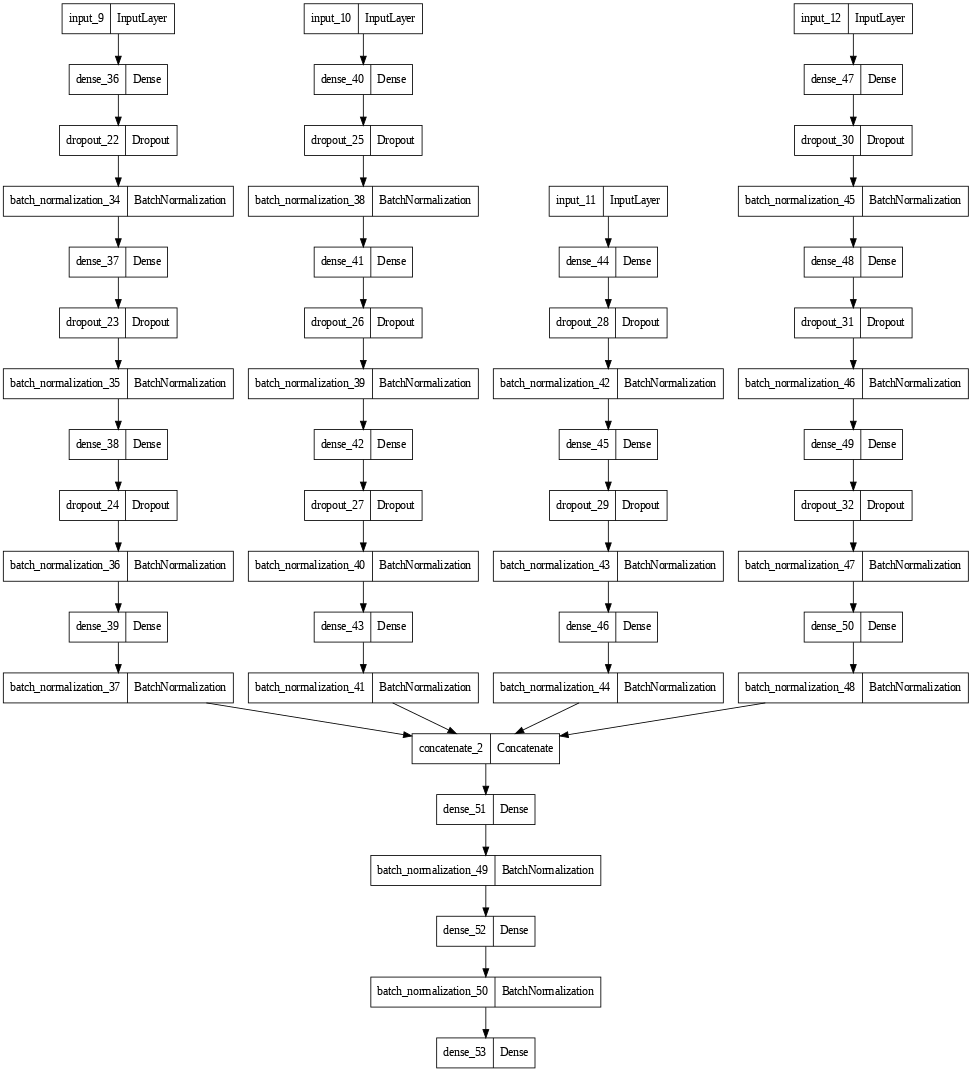

In [95]:
utils.plot_model(model_final, dpi=60)

In [96]:
model_final.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 400)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 400)]        0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 1000)         201000      ['input_9[0][0]']                
                                                                                            

Epoch 1/30
176/176 [==============================] - 86s 430ms/step - loss: 1.1879 - accuracy: 0.4815 - val_loss: 1.9454 - val_accuracy: 0.0000e+00
Epoch 2/30
176/176 [==============================] - 79s 447ms/step - loss: 0.9083 - accuracy: 0.5819 - val_loss: 1.3466 - val_accuracy: 0.1467
Epoch 3/30
176/176 [==============================] - 72s 407ms/step - loss: 0.7321 - accuracy: 0.6752 - val_loss: 0.3982 - val_accuracy: 0.9145
Epoch 4/30
176/176 [==============================] - 73s 413ms/step - loss: 0.6487 - accuracy: 0.7176 - val_loss: 0.2897 - val_accuracy: 0.9302
Epoch 5/30
176/176 [==============================] - 79s 450ms/step - loss: 0.5867 - accuracy: 0.7528 - val_loss: 0.2417 - val_accuracy: 0.9017
Epoch 6/30
176/176 [==============================] - 73s 415ms/step - loss: 0.5417 - accuracy: 0.7764 - val_loss: 0.2252 - val_accuracy: 0.9487
Epoch 7/30
176/176 [==============================] - 72s 408ms/step - loss: 0.5147 - accuracy: 0.7870 - val_loss: 0.1926 - va

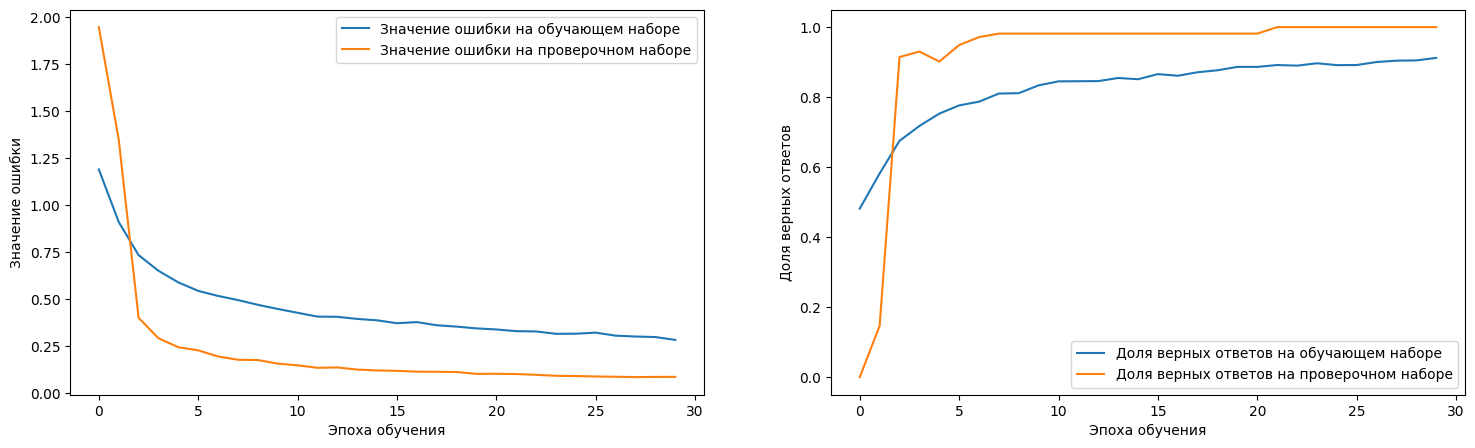

In [97]:
# Обучение модели
model_final.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_final.fit([x_train_harm, x_train_Diag, x_train_gz, x_train_recom], 
                           y_train,
                           shuffle=True,
                           batch_size=16, 
                           epochs=30, 
                           validation_split=0.2,
                           verbose=1)

# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

In [98]:
# Сохраним модель на диске
model_final.save( 'model_7th.h5' )

In [ ]:
files.download(filename='model_7th.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
# Загрузка модели
model_download = tf.keras.models.load_model('model_7th.h5')

110/110 [==============================] - 7s 61ms/step


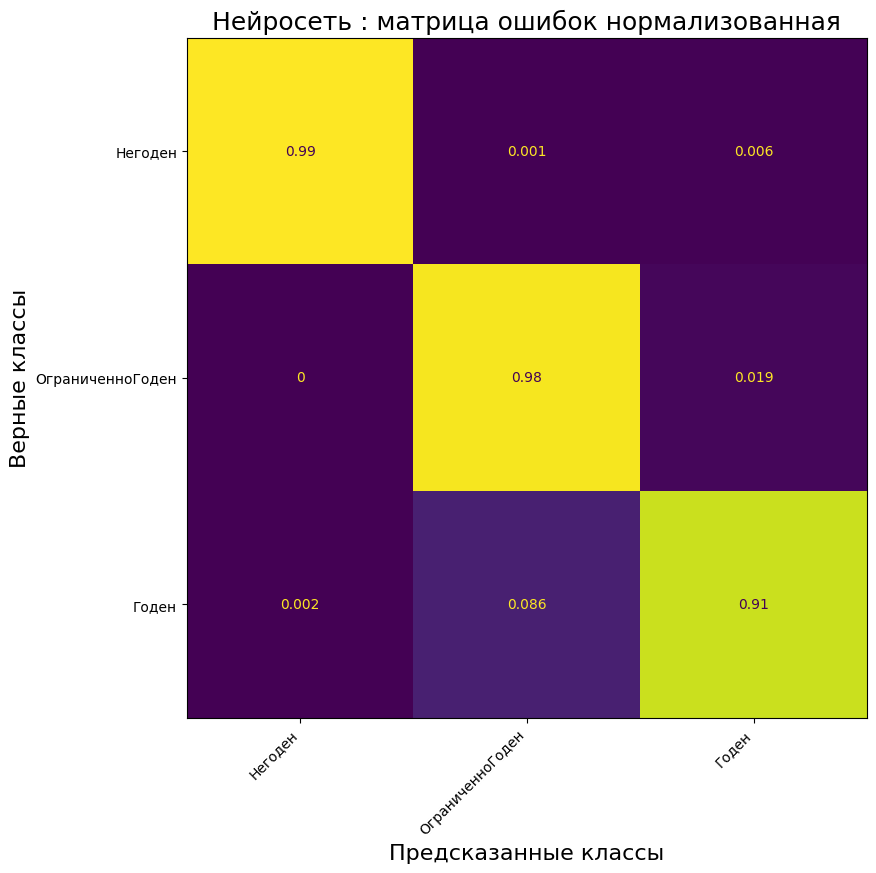

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  96%


In [100]:
# Запуск предсказания и визуализация
eval_model(model_download, [x_train_harm, x_train_Diag, x_train_gz, x_train_recom], 
                           y_train, class_labels = CLASS_DICT)

In [101]:
# Пример предсказания

# обновляем номера индексов
dffix5=dffix5.reset_index(drop=True)

# Получаем список номеров строк (индексов) с соответсвующими классами           
indexes_0 = dffix5.loc[dffix5['ЗаключениеМК'] == 'Негоден'].index.tolist()
indexes_1 = dffix5.loc[dffix5['ЗаключениеМК'] == 'ОграниченноГоден'].index.tolist()
indexes_2 = dffix5.loc[dffix5['ЗаключениеМК'] == 'Годен'].index.tolist()

# Случайно выбираем по одному представителю из класса
n_0 = random.choice(indexes_0)
n_1 = random.choice(indexes_1)
n_2 = random.choice(indexes_2)

# Предсказание по сформированной выборке Вредности и Диагноза
y_pred = model_download.predict([x_train_harm, x_train_Diag, x_train_gz, x_train_recom])

# Перевод полученного вектора в номера классов (0,1,2)
y = np.argmax(y_pred, axis=-1)

# Сформируем таблицу с выводом реальных значений и предсказания
df_pred = pd.DataFrame({'Реальное заключение': ['Негоден', 'ОграниченноГоден', 'Годен'],
                   'Реальный вектор': [y_train[n_0], y_train[n_1], y_train[n_2]],
                   'Реальный класс': [y_data[n_0], y_data[n_1], y_data[n_2]],
                   'Предсказанный вектор': [y_pred[n_0], y_pred[n_1], y_pred[n_2]],
                   'Предсказанный класс': [y[n_0], y[n_1], y[n_2]],
                   'ГЗ': [dffix5.iloc[n_0][1], dffix5.iloc[n_1][1], dffix5.iloc[n_2][1]],
                   'Вредность': [dffix5.iloc[n_0][2], dffix5.iloc[n_1][2], dffix5.iloc[n_2][2]],
                   'Диагнозы': [dffix5.iloc[n_0][3], dffix5.iloc[n_1][3], dffix5.iloc[n_2][3]],
                   'Рекомендации': [dffix5.iloc[n_0][4], dffix5.iloc[n_1][4], dffix5.iloc[n_2][4]]
                   })

df_pred['Предсказанный вектор'] = df_pred['Предсказанный вектор'].apply(format_vector)

df_pred

110/110 [==============================] - 6s 59ms/step


,Реальное заключение,Реальный вектор,Реальный класс,Предсказанный вектор,Предсказанный класс,ГЗ,Вредность,Диагнозы,Рекомендации
0,Негоден,"[1.0, 0.0, 0.0]",0,"[0.97, 0.03, 0.01]",0,,9,Нарушение функции вестибулярного анализатора л...,
1,ОграниченноГоден,"[0.0, 1.0, 0.0]",1,"[0.0, 0.97, 0.03]",1,IIIа,1.50,"Общий медицинский осмотр,Астигматизм,Общий мед...","Наблюдение офтальмолога по мж,набдюдение по ме..."
2,Годен,"[0.0, 0.0, 1.0]",2,"[0.01, 0.68, 0.31]",1,II,"4.4,15","Общий медицинский осмотр,Миопия,Общий медицинс...",Наблюдение офтальмолога по мж


In [102]:
# Сформируем отдельную функцию, которая по получаемой тестовой выборке сделает предсказание и выдаст результат
def getpred(df_in):
  # Получаем на вход некую таблицу данных вида аналогичного первоначально предоставленной
  # Подготовка таблицы данных
  # Убираем полностью пустые строки
  df_in = df_in.dropna(axis=1, how='all')

  # Убираем строки в которых отстутствует одно из встреченных заключений Профпатолога (ПП)
  df_in = df_in[df_in['ЗаключениеМК'].isin(['Годен',
                                      'ГоденСКоррекциейЗрения',
                                      'ВременноНегоден',
                                      'НуждаетсяВДообследованииИЛечении',
                                      'ОграниченноГоден',
                                      'ГоденБезРаботНаВысотах'])]

  # Приводим к 3-м классам (Годен, Негоден, ОграниченноГоден)
  df_in.loc[df_in['ЗаключениеМК'] == 'ВременноНегоден', 'ЗаключениеМК'] = 'Негоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'НуждаетсяВДообследованииИЛечении', 'ЗаключениеМК'] = 'Негоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения', 'ЗаключениеМК'] = 'ОграниченноГоден'
  df_in.loc[df_in['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах', 'ЗаключениеМК'] = 'ОграниченноГоден'

  # Для удобства обращения к столбцу, переименуем его в название из одного слова
  df_in.rename(columns = {'Диспансерная Группа':'ГруппаЗдоровья'}, inplace = True )

  # Оставляем только значащие для нас колонки: Заключение ПП, Вредность и Диагнозы узких специалистов в текстовом представлении
  df_in = df_in[['ЗаключениеМК',
'ГруппаЗдоровья',
'Вредность',
'Психиатрия Наркология1 Диагноз Представление1',
'Офтальмология1_ДиагнозПредставление1',
'Оториноларингология1_ДиагнозПредставление1',
'Гинекология1_ДиагнозПредставление1',
'Стоматология1_ДиагнозПредставление1',
'Дерматовенерология1_ДиагнозПредставление1',
'Неврология1_ДиагнозПредставление1',
'Терапия1_ДиагнозПредставление1',
'Хирургия1_ДиагнозПредставление1',
'Офтальмология1_ДиагнозПредставление2',
'Терапия2_ДиагнозПредставление1',
'ЛабораторныеИсследования1_ХР_Рекомендация1Представление',
 'ПсихиатрияНаркология1_ХР_Рекомендация1Представление',
 'Офтальмология1_ХР_Рекомендация1Представление',
 'Офтальмология1_ХР_Рекомендация2Представление',
 'Оториноларингология1_ХР_Рекомендация1Представление',
 'Гинекология1_ХР_Рекомендация1Представление',
 'Гинекология1_ХР_Рекомендация2Представление',
 'ФункциональнаяДиагностика1_ХР_Рекомендация1Представление',
'Стоматология1_ХР_Рекомендация1Представление',
'Терапия1_ХР_Рекомендация2Представление',
'Дерматовенерология1_ХР_Рекомендация1Представление',
'Дерматовенерология1_ХР_Рекомендация2Представление',
'Неврология1_ХР_Рекомендация1Представление',
'УЗИДиагностика1_Заключение_ЗначениеПредставление',
'Хирургия1_ХР_Рекомендация1Представление',
'Терапия2_ХР_Рекомендация1Представление'
  ]]

  # Заменяем отсутсвтующие записи узких специалистов в пробелы
  df_in=df_in.fillna('')

  # Обобщенный диагноз - собирем диагнозы узких специалистов в одну строку через запятую
  df_in['Свод_Диагноз'] = (df_in['Психиатрия Наркология1 Диагноз Представление1'].map(str) + ','
  + df_in['Офтальмология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Оториноларингология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Гинекология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Стоматология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Дерматовенерология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Неврология1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Терапия1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Хирургия1_ДиагнозПредставление1'].map(str)+ ','
  + df_in['Офтальмология1_ДиагнозПредставление2'].map(str)+ ','
  + df_in['Терапия2_ДиагнозПредставление1'].map(str))


  # Обобщенная рекомендация
  df_in['Рекомендации'] = (df_in['ЛабораторныеИсследования1_ХР_Рекомендация1Представление'].map(str) + ','
  + df_in['ПсихиатрияНаркология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Офтальмология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Офтальмология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Оториноларингология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Гинекология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Гинекология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['ФункциональнаяДиагностика1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Стоматология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Дерматовенерология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Дерматовенерология1_ХР_Рекомендация2Представление'].map(str)+ ','
  + df_in['Неврология1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['УЗИДиагностика1_Заключение_ЗначениеПредставление'].map(str)+ ','
  + df_in['Хирургия1_ХР_Рекомендация1Представление'].map(str)+ ','
  + df_in['Терапия2_ХР_Рекомендация1Представление'].map(str))

  # Упрвостим таблицу данных до 5 столбцов
  df_in = df_in[['ЗаключениеМК',
                 'ГруппаЗдоровья',
                 'Вредность',
                 'Свод_Диагноз',
                 'Рекомендации']]

  # Получаем новую таблицу данных
  df_res1=diag_adv(df_in)
  df_res=recom_adv(df_res1)

  # Удаляем строки с отстуствующими записями всех узких специалистов                    
  df_res = df_res[df_res['Диагнозы']!='']

  # обновляем номера индексов
  df_res=df_res.reset_index(drop=True)
  return df_res

In [103]:
# Функция преобразования данных из таблицы во входные данные для модели

def getXdata (df_res):
  # Извлечение текстов о вредности для выборки
  harm_text = extract_harm_text(df_res) 

  tokenizer_harm.fit_on_texts(harm_text)
  items_harm = list(tokenizer_harm.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  harm_seq = tokenizer_harm.texts_to_sequences(harm_text)

  # Преобразование последовательностей индексов в bag of words
  x_harm = tokenizer_harm.sequences_to_matrix(harm_seq)

  # Извлечение текстов о сводном диагнозе для выборки
  Diag_text = extract_Diag_text(df_res) 

  tokenizer_Diag.fit_on_texts(Diag_text)
  items_Diag = list(tokenizer_Diag.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  Diag_seq = tokenizer_Diag.texts_to_sequences(Diag_text)

  # Преобразование последовательностей индексов в bag of words
  x_diag = tokenizer_Diag.sequences_to_matrix(Diag_seq)


  # Извлечение текстов о рекомендациях для выборки
  recom_text = extract_recom_text(df_res) 

  tokenizer_recom.fit_on_texts(recom_text)
  items_recom = list(tokenizer_recom.word_index.items())

  # Преобразование текстов в последовательность индексов согласно частотному словарю
  recom_seq = tokenizer_recom.texts_to_sequences(recom_text)

  # Преобразование последовательностей индексов в bag of words
  x_recom = tokenizer_recom.sequences_to_matrix(recom_seq)

   

  return x_harm, x_diag, x_recom


In [104]:
# Формирование выборки из тестовой таблицы
x_test_harm, x_test_diag, x_test_recom = getXdata (dffix5[:10])

x_test_gz = extract_gz(dffix5[:10])

y_data_test, y_vect_test = Y_to_OHE(dffix5[:10])

y_vec_list = list(y_vect_test)
y_data_list = list(y_data_test)

In [105]:
# Предсказание по сформированной выборке Вредности и Диагноза
y_pred = model_download.predict([x_test_harm, x_test_diag, x_test_gz, x_test_recom])

y_pred_list = list(y_pred)

# Перевод полученного вектора в номера классов (0,1,2)
y = np.argmax(y_pred, axis=-1)

y_list = list (y)

1/1 [==============================] - 0s 54ms/step


In [106]:
# Создадим списки входных данных
dftest=dffix5.iloc[:10]
x_harm_list = list(dftest['Вредность'])
x_diag_list = list(dftest['Диагнозы'])
x_recom_list = list(dftest['Рекомендации'])
x_gz_list = list(dftest['ГруппаЗдоровья'])

In [107]:
# Сформируем таблицу с выводом реальных значений и предсказания
df_pred = pd.DataFrame({'РеалВектор': y_vec_list,
                   'РеалКласс': y_data_list,
                   'ПредВектор': y_pred_list,
                   'ПредКласс': y_list,
                   'ГруппаЗдоровья': x_gz_list,
                   'Вредный фактор': x_harm_list,
                   'Диагнозы': x_diag_list,
                   'Рекомендации': x_recom_list
                   })
# Обработка вывода вектора
df_pred['ПредВектор'] = df_pred['ПредВектор'].apply(format_vector)

df_pred

,РеалВектор,РеалКласс,ПредВектор,ПредКласс,ГруппаЗдоровья,Вредный фактор,Диагнозы,Рекомендации
0,"[0.0, 0.0, 1.0]",2,"[0.04, 0.09, 0.87]",2,I,11.4,"Общий медицинский осмотр,Общий медицинский осм...",
1,"[0.0, 0.0, 1.0]",2,"[0.04, 0.03, 0.93]",2,IIIа,4.2.5,"Общий медицинский осмотр,Общий медицинский осм...",
2,"[0.0, 1.0, 0.0]",1,"[0.01, 0.93, 0.07]",1,II,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс...",Допуск с ношением средств оптической коррекции...
3,"[0.0, 0.0, 1.0]",2,"[0.02, 0.09, 0.89]",2,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",Эхопатологии на момент осмотра не выявлено
4,"[0.0, 1.0, 0.0]",1,"[0.0, 0.7, 0.29]",1,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Использование средств оптической коррекции зре...
5,"[0.0, 0.0, 1.0]",2,"[0.01, 0.69, 0.31]",1,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",Эхопатологии на момент осмотра не выявлено
6,"[0.0, 1.0, 0.0]",1,"[0.01, 0.7, 0.3]",1,II,11.1,"Миопия,Общий медицинский осмотр,Общий медицинс...",Использование средств оптической коррекции зре...
7,"[0.0, 0.0, 1.0]",2,"[0.04, 0.4, 0.56]",2,II,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед...",\r\nВизуализация поджелудочной железы затрудне...
8,"[0.0, 0.0, 1.0]",2,"[0.02, 0.09, 0.89]",2,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",Эхопатологии на момент осмотра не выявлено
9,"[0.0, 0.0, 1.0]",2,"[0.02, 0.09, 0.89]",2,I,11.1,"Общий медицинский осмотр,Общий медицинский осм...",Эхопатологии на момент осмотра не выявлено


In [ ]:
# Пример текста о вредности и диагнозе
print(df_pred.values[5])

[array([0., 1., 0.], dtype=float32) 1 list([0.05, 0.32, 0.63]) 2 'II'
 '11.1'
 'Астигматизм,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр']
